In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **PySpark-ile-cok-Sinifli-Metin-Siniflandirma**


In [ ]:
pip install findspark

In [ ]:
pip install pyspark findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e9a3e65b566cc2dff1d7cec903d53ea6310a14b1e765ad9f428a22f8831c2e8b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import findspark
findspark.init('')
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.master("local[4]") \
.appName("multiclass") \
.config("spark.executor.memory","4g") \
.config("spark.driver.memory","2g") \
.getOrCreate()


In [ ]:
data = spark.read.option("header","True").option("inferSchema","True").option("sep",",").csv("/content/drive/MyDrive/MachineLearning/onderhoca/7allV03.csv")

In [ ]:
from pyspark.sql.functions import col

# by top 20 categories
data.groupBy("Category").count().orderBy(col("count").desc()).show()

+----------+-----+
|  Category|count|
+----------+-----+
|  siyaset |  700|
|  ekonomi |  700|
|    dunya |  700|
|   kultur |  700|
|   saglik |  700|
|     spor |  700|
|teknoloji |  700|
+----------+-----+



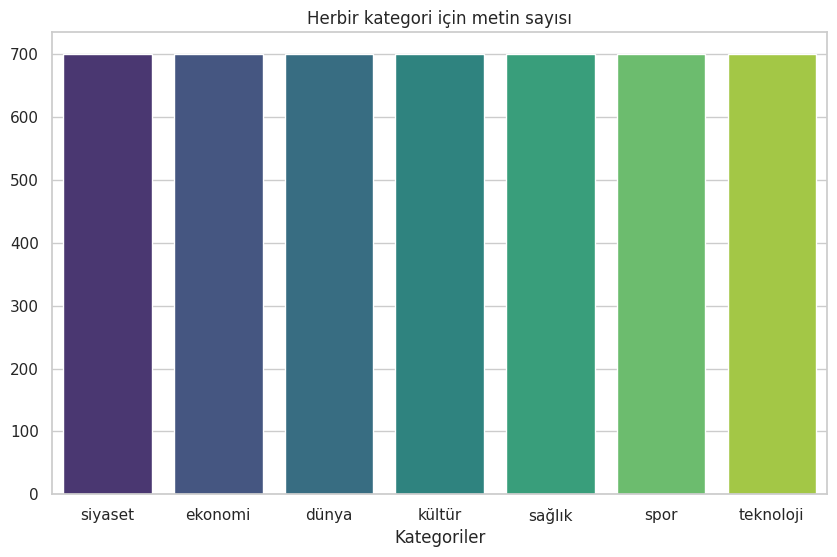

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kategoriler ve değerler
categories = ['siyaset', 'ekonomi', 'dünya', 'kültür', 'sağlık', 'spor', 'teknoloji']
values = [700, 700, 700, 700, 700, 700, 700]

# Seaborn tema ayarı
sns.set(style="whitegrid")

# Görselleştirme
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu ayarla
sns.barplot(x=categories, y=values, palette="viridis")  # Seaborn'un barplot fonksiyonunu kullanarak grafiği oluştur
plt.title('Herbir kategori için metin sayısı')
plt.xlabel('Kategoriler')
plt.ylabel('')
plt.show()

In [ ]:
data.columns

['category', 'text']

In [ ]:
data.show(5)

+--------+--------------------+
|category|                text|
+--------+--------------------+
|siyaset | 3 milyon ile ön ...|
|siyaset | mesut_yılmaz yüc...|
|siyaset | disko lar kaldır...|
|siyaset | sarıgül anayasa_...|
|siyaset | erdoğan idamın b...|
+--------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

stopwords = []
with open(r'/content/drive/MyDrive/MachineLearning/onderhoca/stopwords.txt', 'r',encoding='utf-8') as f:
  for word in f:
    word = word.split('\n')
    stopwords.append(word[0])

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
label_stringIdx


StringIndexer_8ebc9307b4cc

In [ ]:
data.show()

+--------+--------------------+
|category|                text|
+--------+--------------------+
|siyaset | 3 milyon ile ön ...|
|siyaset | mesut_yılmaz yüc...|
|siyaset | disko lar kaldır...|
|siyaset | sarıgül anayasa_...|
|siyaset | erdoğan idamın b...|
|siyaset | hüseyin_çelik bu...|
|siyaset | yılmaz_özdil e b...|
|siyaset | bakanlıklar lale...|
|siyaset | iktidarın gerçek...|
|siyaset | vural dan karada...|
|siyaset | 100  türkiye ve...|
|siyaset | örgütler ölümcül...|
|siyaset | bakan_kılıç tan ...|
|siyaset | boşboğazlık yapa...|
|siyaset | yaptığım bir mül...|
|siyaset | bakan_yıldırım y...|
|siyaset | chp diyarbakır a...|
|siyaset | akp mutabakata e...|
|siyaset | demokrasimiz ile...|
|siyaset | patriotlar için ...|
+--------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

In [ ]:
dataset.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+-----+
|category|                text|               words|            filtered|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
|siyaset | 3 milyon ile ön ...|[3, milyon, ile, ...|[3, n, se, im, va...|(10000,[0,1,2,3,4...|  4.0|
|siyaset | mesut_yılmaz yüc...|[mesut_y, lmaz, y...|[mesut_y, lmaz, y...|(10000,[0,1,2,3,4...|  4.0|
|siyaset | disko lar kaldır...|[disko, lar, kald...|[disko, lar, kald...|(10000,[0,1,2,3,4...|  4.0|
|siyaset | sarıgül anayasa_...|[sar, g, l, anaya...|[sar, g, l, anaya...|(10000,[0,1,2,3,4...|  4.0|
|siyaset | erdoğan idamın b...|[erdo, an, idam, ...|[erdo, an, idam, ...|(10000,[0,1,2,3,4...|  4.0|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
category_sutunu = dataset.select('category').toPandas()['category']
print(category_sutunu)

0         siyaset 
1         siyaset 
2         siyaset 
3         siyaset 
4         siyaset 
           ...    
4895    teknoloji 
4896    teknoloji 
4897    teknoloji 
4898    teknoloji 
4899    teknoloji 
Name: category, Length: 4900, dtype: object


In [ ]:
label_sutunu = dataset.select('label').toPandas()['label']
print(label_sutunu)

0       4.0
1       4.0
2       4.0
3       4.0
4       4.0
       ... 
4895    6.0
4896    6.0
4897    6.0
4898    6.0
4899    6.0
Name: label, Length: 4900, dtype: float64


In [ ]:
kategori_label_ciftleri = dataset.select('category', 'label').distinct().collect()

# Sonuçları ekrana yazdır
for row in kategori_label_ciftleri:
    print(f"Kategori: {row['category']}, Etiket: {row['label']}")

Kategori: dunya , Etiket: 0.0
Kategori: siyaset , Etiket: 4.0
Kategori: ekonomi , Etiket: 1.0
Kategori: spor , Etiket: 5.0
Kategori: saglik , Etiket: 3.0
Kategori: kultur , Etiket: 2.0
Kategori: teknoloji , Etiket: 6.0


<ipython-input-116-ed8fd1bf1408>:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=pandas_df['label'])


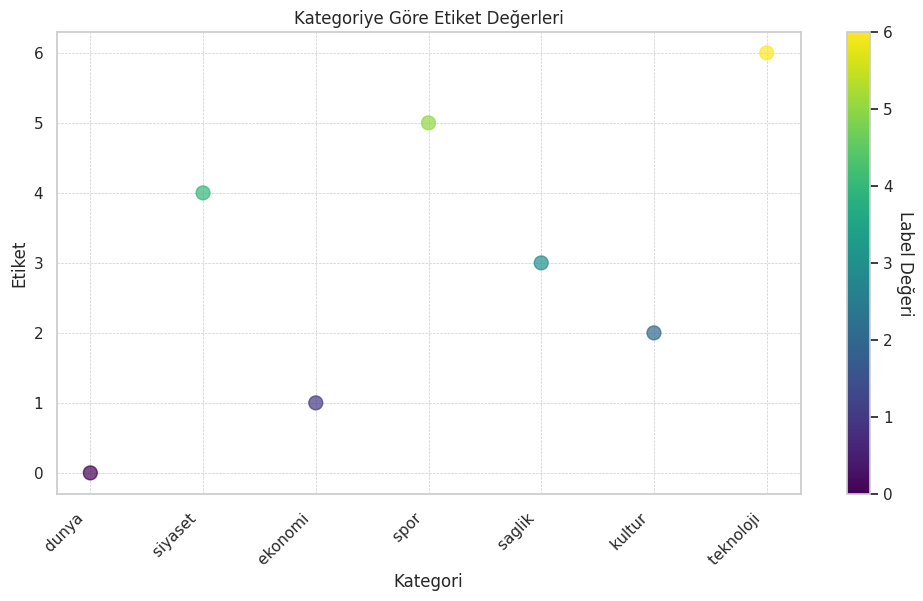

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# SparkSession oluşturun (zaten oluşturulmuşsa bu satırı atlayabilirsiniz)
spark = SparkSession.builder.appName("example").getOrCreate()

# Her bir kategoriye karşılık gelen label değerlerini bulmak
kategori_label_df = dataset.select('category', 'label').distinct()

# PySpark DataFrame'i Pandas DataFrame'e dönüştür
pandas_df = kategori_label_df.toPandas()

# Sabit boyut belirle
sabit_boyut = 100

# Veriyi görselleştir
plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['category'], pandas_df['label'], s=sabit_boyut, c=pandas_df['label'], cmap='viridis', alpha=0.7)
plt.xlabel('Kategori')
plt.ylabel('Etiket')
plt.title('Kategoriye Göre Etiket Değerleri')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Renk çubuğunu ekleme
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=pandas_df['label'].min(), vmax=pandas_df['label'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=pandas_df['label'])
cbar.set_label('Label Değeri', rotation=270, labelpad=15)

plt.show()

# **Verimizi Train ve Test olarak bölelim (%70-%30)**

In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 3410
Test Dataset Count: 1490


In [ ]:
trainingData.show()

+--------+--------------------+--------------------+--------------------+--------------------+-----+
|category|                text|               words|            filtered|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
|  dunya | 1 26 milyon insa...|[1, 26, milyon, i...|[1, 26, insan, et...|(10000,[0,1,2,3,4...|  0.0|
|  dunya | 100 araç birbiri...|[100, ara, birbir...|[100, ara, birbir...|(10000,[0,1,2,3,4...|  0.0|
|  dunya | 100 bin abd li a...|[100, bin, abd, l...|[100, abd, li, ay...|(10000,[0,1,2,3,5...|  0.0|
|  dunya | 140 araç birbiri...|[140, ara, birbir...|[140, ara, birbir...|(10000,[0,1,2,3,4...|  0.0|
|  dunya | 140 araç birbiri...|[140, ara, birbir...|[140, ara, birbir...|(10000,[0,1,2,3,4...|  0.0|
|  dunya | 15 taliban milit...|[15, taliban, mil...|[15, taliban, mil...|(10000,[0,1,4,6,8...|  0.0|
|  dunya | 150 araç birbiri...|[150, ara, birbir...|[150, ara, birbir...|(10000,[0,1,2,3,4.

**Logistic Regression**

In [ ]:
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [ ]:
predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| israil in gazze ye saldırı...|  dunya |[0.9999683646346719,4.11800...|  0.0|       0.0|
| filistin de bayram havası ...|  dunya |[0.999711439802877,6.910361...|  0.0|       0.0|
| türkiye nin yerini mısır a...|  dunya |[0.9960908785302134,2.92440...|  0.0|       0.0|
| cenaze için geniş güvenlik...|  dunya |[0.9945769544668055,3.57774...|  0.0|       0.0|
| esad kimyasal silah kullan...|  dunya |[0.9863885646361877,8.83861...|  0.0|       0.0|
| endonezya da çatışmalar 14...|  dunya |[0.9857707559567038,0.00141...|  0.0|       0.0|
| işte 7 gün süren savaşın b...|  dunya |[0.9850240900667753,0.00423...|  0.0|       0.0|
| kutlama bitti sıra icraatt...|  dunya |[0.9836911096504122,0.00785...|  0.0|       0.0|
| bayram ö

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_lr = evaluator.evaluate(predictions)
acc_lr

0.8645874482033994

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

# Add HashingTF and IDF to transformation
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

# Redo Pipeline
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

In [ ]:
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [ ]:
predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| israil in gazze ye saldırı...|  dunya |[0.999800723181371,5.028763...|  0.0|       0.0|
| filistin de bayram havası ...|  dunya |[0.9982572370664036,2.32410...|  0.0|       0.0|
| cenaze için geniş güvenlik...|  dunya |[0.9919766499939625,5.85961...|  0.0|       0.0|
| 7 bin suriyeli ceylanpınar...|  dunya |[0.9896318666983235,5.55130...|  0.0|       0.0|
| esad kimyasal silah kullan...|  dunya |[0.9855076173613029,0.00194...|  0.0|       0.0|
| işte 7 gün süren savaşın b...|  dunya |[0.9782280178847401,0.00227...|  0.0|       0.0|
| türkiye nin yerini mısır a...|  dunya |[0.9688002733101782,0.00198...|  0.0|       0.0|
| çin den filistin ve israil...|  dunya |[0.942516506904336,0.006003...|  0.0|       0.0|
| putin  

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8645874482033994

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_lr_cv = evaluator.evaluate(predictions)
acc_lr_cv

0.8789258939179418

In [ ]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1)

# train the model
model = nb.fit(trainingData)

In [ ]:
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| iran amerikan uçağına ateş...|  dunya |[1.0,7.61463409390512E-18,1...|  0.0|       0.0|
| bağlan da otobüs devrildi ...|  dunya |[1.0,7.202084487081113E-18,...|  0.0|       0.0|
| felaket bölgesinde kar yağ...|  dunya |[1.0,4.660413376760917E-20,...|  0.0|       0.0|
| ab den iran gazına yasak a...|  dunya |[1.0,1.6102390799965523E-20...|  0.0|       0.0|
| ürdün de binler sokağa dök...|  dunya |[1.0,6.992908841668539E-22,...|  0.0|       0.0|
| berlin de yunanistan büyük...|  dunya |[1.0,3.811988691340665E-24,...|  0.0|       0.0|
| irak ta bombalı saldırılar...|  dunya |[1.0,1.340663746846568E-24,...|  0.0|       0.0|
| pakistan da etnik çatışma ...|  dunya |[1.0,9.254384475661462E-26,...|  0.0|       0.0|
| norveç p

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_nb = evaluator.evaluate(predictions)
acc_nb

0.8904502686297682

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [ ]:
predictions = rfModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| israil in gazze ye saldırı...|  dunya |[0.19932775623196494,0.1379...|  0.0|       0.0|
| mısır abd den israil saldı...|  dunya |[0.19872076949974568,0.1376...|  0.0|       0.0|
| çin den filistin ve israil...|  dunya |[0.1957395549444914,0.14447...|  0.0|       0.0|
| israil den ateşkes ihlali ...|  dunya |[0.19395457269605873,0.1421...|  0.0|       0.0|
| mısır başbakanı gazze ye g...|  dunya |[0.19356866534239414,0.1375...|  0.0|       0.0|
| israil den esad a sert yan...|  dunya |[0.19305321287972227,0.1387...|  0.0|       0.0|
| ailesinden 10 kişiyi kaybe...|  dunya |[0.19302737761179334,0.1466...|  0.0|       0.0|
| israil in saldırıları kabu...|  dunya |[0.19301994219258184,0.1385...|  0.0|       0.0|
| israil d

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_rf = evaluator.evaluate(predictions)
acc_rf

0.7814712889052091

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# Chain indexers and tree in a Pipeline

# Train model.  This also runs the indexers.
model = dt.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_dt = evaluator.evaluate(predictions)
acc_dt

0.47043469044347624

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

(train, test) = dataset.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction" , metricName="accuracy")
acc_ovr = evaluator.evaluate(predictions)
acc_ovr

0.8843058350100603

In [ ]:
#k-fold sonuçları
modeller = pd.DataFrame({'Model':['Logistik Regresyon',
                                  'Naive Bayes',
                                  'Random Forest',
                                  'Decision Tree',
                                  'One-vs-All',
                                 ],
                        'Score':[acc_lr_cv*100 , acc_nb*100 , acc_rf*100 , acc_dt*100 , acc_ovr*100 ]})
modeller

,Model,Score
0,Logistik Regresyon,87.892589
1,Naive Bayes,89.045027
2,Random Forest,78.147129
3,Decision Tree,47.043469
4,One-vs-All,88.430584


In [ ]:
model_sort = modeller.sort_values(by='Score',ascending=False)
model_sort

,Model,Score
1,Naive Bayes,89.045027
4,One-vs-All,88.430584
0,Logistik Regresyon,87.892589
2,Random Forest,78.147129
3,Decision Tree,47.043469


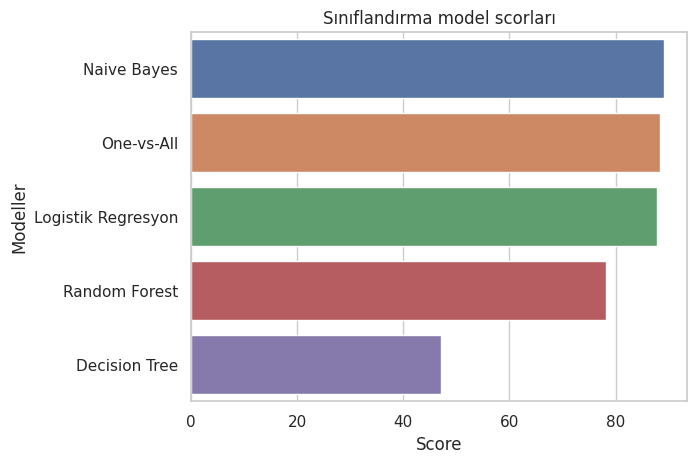

In [ ]:
sns.barplot( x= model_sort.Score , y=model_sort.Model )

plt.xlabel("Score")
plt.ylabel("Modeller")
plt.title("Sınıflandırma model scorları")
plt.show()

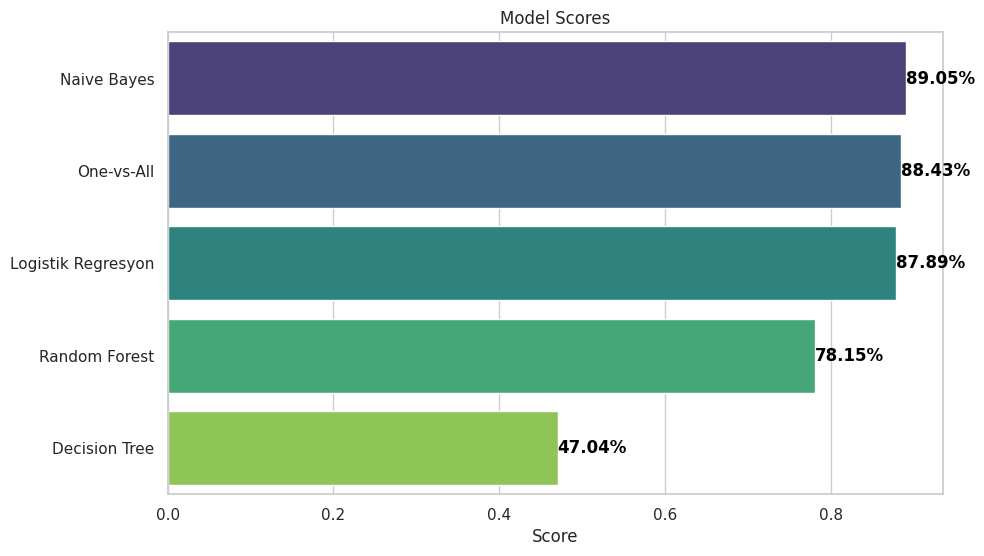

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ["Naive Bayes", "One-vs-All", "Logistik Regresyon", "Random Forest", "Decision Tree"]
scores = [89.045027, 88.430584, 87.892589, 78.147129, 47.043469]

# Dönüşüm: Skorları yüzdelik formatına çevirme
percentage_scores = [score / 100 for score in scores]

# Set a color palette
custom_colors = sns.color_palette("viridis", len(models))

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=percentage_scores, y=models, palette=custom_colors)

# Display the scores on the bars
for index, value in enumerate(percentage_scores):
    bar_plot.text(value, index, f'{value:.2%}', ha="left", va="center", color='black', fontweight='bold')

# Customize the plot
plt.xlabel('Score')
plt.title('Model Scores')

plt.show()

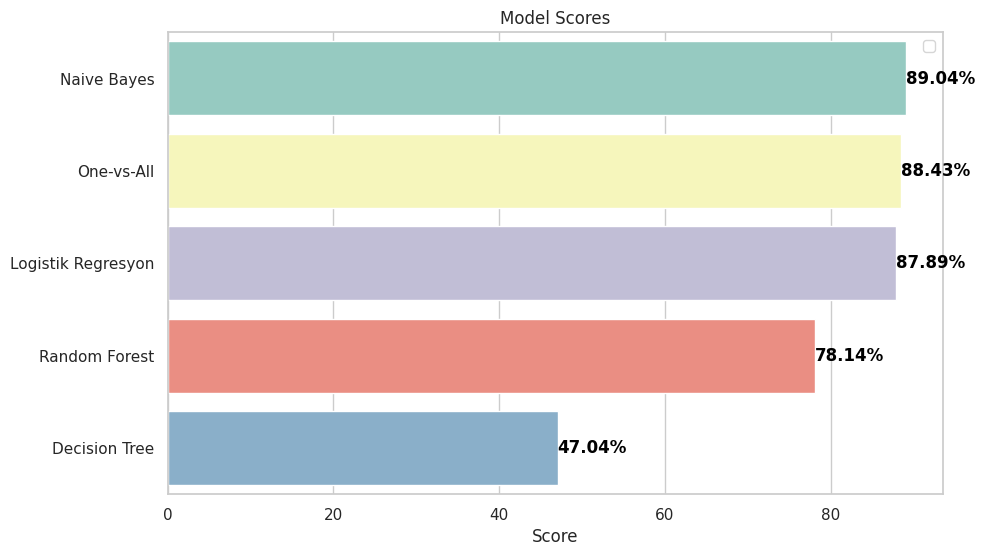

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ["Naive Bayes", "One-vs-All", "Logistik Regresyon", "Random Forest", "Decision Tree"]
scores = [89.04, 88.43, 87.89, 78.14, 47.04]

# Set a different color palette
custom_colors = sns.color_palette("Set3", len(models))

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=scores, y=models, palette=custom_colors)

# Display the scores on the bars
for index, value in enumerate(scores):
    bar_plot.text(value, index, f'{value:.2f}%', ha="left", va="center", color='black', fontweight='bold')

# Customize the plot
plt.xlabel('Score')
plt.title('Model Scores')


# Add legend
plt.legend()

# Show the plot
plt.show()